In [15]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from trans import *
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

In [16]:
data = Dataset('data/transcriptions/train.csv')
words_vocab = data.words_vocab
trans_vocab = data.trans_vocab

In [93]:
class DotAttention(nn.Module):
    def __init__(self):
        super(DotAttention, self).__init__()
    
    def forward(self, query, context, mask = None):
        '''
        Inputs:
            query:   (batch x dec_seq_len x hidden_size) - outputs of decoder
            context: (batch x enc_seq_len x hidden_size) - outputs of encoder
            mask:    (batch x enc_seq_len)
        Outputs:
            weights: (batch x dec_seq_len x enc_seq_len)
            outputs: (batch x dec_seq_len x hidden)
        '''
        dec_seq_len = query.size()[1]
        logits  = torch.matmul(query, context.transpose(1, 2)) #b x dec_seq_len x enc_seq_len
        # под вопросом
        if mask is not None:
            mask = mask.unsqueeze(1)
            logits.masked_fill_(1-mask, -float('inf'))         #b x dec_seq_len x enc_seq_len
        weights = F.softmax(logits, 1)                         #b x dec_seq_len x enc_seq_len
        outputs = torch.matmul(weights, context)               #b x dec_seq_len x hidden_size

        return weights, outputs
    
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru       = nn.GRU(emb_size, hidden_size, batch_first=True)
    
    def forward(self, source, source_lens=None):
        embedded = self.embedding(source)
        if source_lens is not None:
            embedded = pack(embedded, source_lens, batch_first=True)
        outs, hidden = self.gru(embedded)
        
        if source_lens is not None:
            outs, _ = unpack(outs, batch_first = True)
        return outs, hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx, attention_type=None):
        super(Decoder, self).__init__()
        
        self.vocab_size  = vocab_size
        self.emb_size    = emb_size
        self.hidden_size = hidden_size
        
        
        self.embedding   = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru         = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.linear1     = nn.Linear(2*hidden_size, hidden_size, bias = False)
        self.linear_out  = nn.Linear(hidden_size, vocab_size)
        
        self.attention   = DotAttention()
            
    def forward(self, batch_in, enc_outputs, hidden, mask_attention = None):
        '''
        Inputs:
            batch_in:    (batch x dec_seq_len)
            enc_outputs: (batch x enc_seq_len x hidden_size)
            hidden:      (batch x hidden_size)
        Outputs:
            logits:  (batch x dec_seq_len x vocab_size)
            hidden: (batch x hidden_size)
        '''
        batch_size  = batch_in.size()[0]
        dec_seq_len = batch_in.size()[1]
        
        embedded         = self.embedding(batch_in)   #b x dec_seq_len x embedding_size   
        hidden           = hidden.unsqueeze(0)        #1 x b x hidden
        dec_outs, hidden = self.gru(embedded, hidden) #b x dec_seq_len x hidden; 1 x b x hidden
        _, context       = self.attention(dec_outs, enc_outputs)  #b x dec_seq_len x enc_seq_len; b x dec_seq_len x hidden
        concat           = torch.cat([dec_outs, context], dim=-1) #b x dec_seq_len x 2*hidden
        linear           = self.linear1(concat)       #b x dec_seq_len x hidden
        nonlinear        = F.tanh(linear)             #b x dec_seq_len x hidden
        logits           = self.linear_out(nonlinear) #b x dec_seq_len x vocab
        logits           = logits.view(-1, self.vocab_size) #b*dec_seq_len x vocab
        return logits, hidden
        
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, len_in_vocab, len_out_vocab, 
                 in_pad_idx=0, out_pad_idx=0, attention_type=None):
        
        super(Model, self).__init__()   
        self.encoder = Encoder(len_in_vocab, emb_size, hidden_size, in_pad_idx)
        self.decoder = Decoder(len_out_vocab, emb_size, hidden_size, out_pad_idx, attention_type)
        self.len_trans_vocab = len_out_vocab
        
    def forward(self, batch_words, words_lens, batch_trans_in, mask_attention):
        outputs, hidden = self.encoder(batch_words, words_lens)
        hidden    = hidden.squeeze(0) #1 x b x hidden -> b x hidden  
        logits, _ = self.decoder(batch_trans_in, outputs, hidden, mask_attention)
        return logits
    
    def generate1(self, bos_idx, eos_idx, batch_words, words_lens, mask_attention):
        with torch.no_grad():
            inp = [bos_idx]
            outs, hidden = self.encoder(batch_words, words_lens) #b x seq_len x hidden, 1 x b x hidden
            hidden = hidden.squeeze(0)                            #b x hidden
            for _ in range(100):
                inp_tensor = torch.LongTensor([inp]).to(batch_words.device)
                logits     = self.decoder(inp_tensor, outs, hidden)
    #             print('inputs', inp_tensor)
    #             print(outs)
    #             print(hidden)
    #             print(logits.size())
    #             print(logits)
    #             print(F.softmax(logits, dim=-1).size())
    #             print(F.softmax(logits, dim=-1))
    #             print(F.softmax(logits, dim=-1)[-1])
    #             print(F.softmax(logits, dim=-1)[-1].topk(1))

                next_token = F.softmax(logits, dim=-1)[-1].topk(1)[1].item()
                inp.append(next_token)
                if next_token == eos_idx:
                    break
            return inp

    def generate(self, bos_idx, eos_idx, batch_words, words_lens, mask_attention):
        with torch.no_grad():
            inp = [bos_idx]
            outs, hidden = self.encoder(batch_words, words_lens)  #b x seq_len x hidden, 1 x b x hidden
            
            for _ in range(100):
                hidden = hidden.squeeze(0)                            #b x hidden
                inp_tensor     = torch.LongTensor([[inp[-1]]]).to(batch_words.device)
                logits, hidden = self.decoder(inp_tensor, outs, hidden)
    #             print('inputs', inp_tensor)
    #             print(outs)
    #             print(hidden)
    #             print(logits.size())
    #             print(logits)
    #             print(F.softmax(logits, dim=-1).size())
    #             print(F.softmax(logits, dim=-1))
    #             print(F.softmax(logits, dim=-1)[-1])
    #             print(F.softmax(logits, dim=-1)[-1].topk(1))

                next_token = F.softmax(logits, dim=-1)[-1].topk(1)[1].item()
                inp.append(next_token)
                if next_token == eos_idx:
                    break
            return inp


In [62]:
# def generate(bos_idx, eos_idx, batch_words, words_lens, mask_attention):
#     with torch.no_grad():
#         inp = [bos_idx]
#         outs, hidden = model.encoder(batch_words, words_lens) #b x seq_len x hidden, 1 x b x hidden
#         hidden = hidden.squeeze(0)                            #b x hidden
#         for _ in range(100):
#             inp_tensor = torch.LongTensor([inp]).to(batch_words.device)
#             logits     = model.decoder(inp_tensor, outs, hidden)
# #             print('inputs', inp_tensor)
# #             print(outs)
# #             print(hidden)
# #             print(logits.size())
# #             print(logits)
# #             print(F.softmax(logits, dim=-1).size())
# #             print(F.softmax(logits, dim=-1))
# #             print(F.softmax(logits, dim=-1)[-1])
# #             print(F.softmax(logits, dim=-1)[-1].topk(1))
            
#             next_token = F.softmax(logits, dim=-1)[-1].topk(1)[1].item()
#             inp.append(next_token)
#             if next_token == eos_idx:
#                 break
#         return inp


# batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(1, sort=True, val=True)
# batch_words     = batch_words.to(device)
# batch_trans_in  = batch_trans_in.to(device)
# words_lens      = words_lens.to(device)
# batch_trans_out = batch_trans_out.to(device)
# mask_attention  = (batch_words != data.words_vocab.pad_idx).unsqueeze(-1)

# inp = generate(data.words_vocab.sos_idx, data.words_vocab.eos_idx, batch_words, words_lens, mask_attention)

# tokens = [data.trans_vocab.idx2token(idx) for idx in inp if idx not in [data.trans_vocab.sos_idx,
#                                                                    data.trans_vocab.eos_idx,
#                                                                    data.trans_vocab.pad_idx]]
# print('Src: ', ''.join([data.words_vocab.idx2token(idx) for idx in batch_words[0].tolist()]))
# print('Pred:', ''.join(tokens))
# print('Real:', ''.join([data.trans_vocab.idx2token(idx) for idx in batch_trans_out[0].tolist() if idx not in [data.trans_vocab.sos_idx,
#                                                                         data.trans_vocab.eos_idx,
#                                                                         data.trans_vocab.pad_idx]]))

In [83]:
decoder = Decoder(len(trans_vocab), 24, 32, trans_vocab.pad_idx)
batch_size = 64
batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(batch_size, sort=True, val=False)


enc_outputs = torch.randn(batch_size, 17, 32)
hidden = torch.randn(batch_size, 32)

decoder(batch_trans_in, enc_outputs, hidden)


/home/rustem/.virtualenvs/dl/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(tensor([[-0.3123, -0.3792, -0.0948,  ...,  0.3630,  0.4003, -0.6500],
         [-0.1718, -0.2830, -0.2249,  ...,  0.1863,  0.0877, -0.4872],
         [ 0.0819, -0.1669, -0.1015,  ...,  0.1413,  0.1088, -0.1521],
         ...,
         [ 0.1155, -0.2616, -0.1001,  ..., -0.2442, -0.0119, -0.2247],
         [ 0.1184, -0.2614, -0.1028,  ..., -0.2532, -0.0132, -0.2293],
         [ 0.1206, -0.2614, -0.1044,  ..., -0.2593, -0.0143, -0.2322]],
        grad_fn=<ViewBackward>),
 tensor([[[ 0.0469,  0.2087, -0.0972,  ...,  0.0246,  0.0357,  0.2660],
          [-0.0201,  0.1522, -0.1190,  ...,  0.0268, -0.1804,  0.2224],
          [ 0.0092,  0.1740, -0.0607,  ...,  0.0475, -0.1181,  0.2475],
          ...,
          [-0.0151,  0.1860, -0.0461,  ...,  0.0247, -0.1329,  0.2435],
          [-0.0067,  0.2131, -0.0447,  ...,  0.0239, -0.1336,  0.2653],
          [-0.0116,  0.2032, -0.0496,  ...,  0.0298, -0.1348,  0.2607]]],
        grad_fn=<ViewBackward>))

In [84]:
attn = DotAttention()
query   = torch.randn(32, 15, 32)
context = torch.randn(32, 17, 32)
mask = torch.ones(32, 17).type(torch.ByteTensor)
mask[:, -1]=0
a = attn(query, context, mask)
print(a[0].size(), a[1].size())

torch.Size([32, 15, 17]) torch.Size([32, 15, 32])


In [85]:
# тестим Attention
outputs = torch.randn(32, 12, 24)
hidden  = torch.randn(32, 24)
attention = DotAttention()
a = attention(outputs, hidden)
a.size()

RuntimeError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

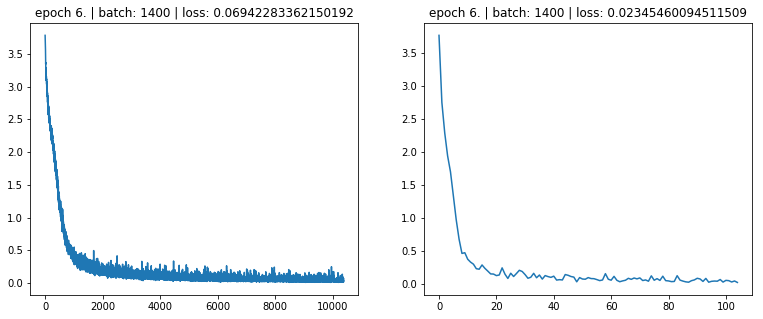

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder    = Encoder(len(words_vocab), 32, 64, words_vocab.pad_idx)
decoder    = Decoder(len(trans_vocab), 32, 64, words_vocab.pad_idx, 'dot')
model      = Model(32, 64, len(words_vocab), len(trans_vocab),\
                  words_vocab.pad_idx, trans_vocab.pad_idx, 'dot').to(device)
optimizer  = optim.Adam(model.parameters())
criterion  = nn.CrossEntropyLoss()
batch_size = 64
num_epochs = 7

trainer   = Trainer(model, data, optimizer, criterion)
trainer.train(num_epochs, batch_size)

In [95]:
def _print(val):
    batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(1, sort=True, val=val)
    batch_words     = batch_words.to(device)
    words_lens      = words_lens.to(device)
    batch_trans_out = batch_trans_out.to(device)
    mask_attention  = (batch_words != data.words_vocab.pad_idx).unsqueeze(-1)

    inp = model.generate(data.words_vocab.sos_idx, data.words_vocab.eos_idx, batch_words, words_lens, mask_attention)
    inp1 = model.generate(data.words_vocab.sos_idx, data.words_vocab.eos_idx, batch_words, words_lens, mask_attention)
            
    tokens = [data.trans_vocab.idx2token(idx) for idx in inp if idx not in [data.trans_vocab.sos_idx,
                                                                       data.trans_vocab.eos_idx,
                                                                       data.trans_vocab.pad_idx]]
    tokens1 = [data.trans_vocab.idx2token(idx) for idx in inp if idx not in [data.trans_vocab.sos_idx,
                                                                       data.trans_vocab.eos_idx,
                                                                       data.trans_vocab.pad_idx]]
    print('Src: ', ''.join([data.words_vocab.idx2token(idx) for idx in batch_words[0].tolist()]))
    print('Pred:', ''.join(tokens))
    print('Pre1:', ''.join(tokens1))
    print('Real:', ''.join([data.trans_vocab.idx2token(idx) for idx in batch_trans_out[0].tolist() if idx not in [data.trans_vocab.sos_idx,
                                                                            data.trans_vocab.eos_idx,
                                                                            data.trans_vocab.pad_idx]]))

In [96]:
for _ in range(10):
    _print(True)
    print()

/home/rustem/.virtualenvs/dl/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Src:  CHAVOUS
Pred: IYIYIY
Pred1: IYIYIY
Real: SHAHVAOS

Src:  SPINOZA
Pred: IYIYZ
Pred1: IYIYZ
Real: SPIHNOWZAH

Src:  BURGOMASTER
Pred: ERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERER
Pred1: ERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERER
Real: BERGAHMAESTER

Src:  URSINI
Pred: IYIYIY
Pred1: IYIYIY
Real: ERSIYNIY

Src:  CONVICTING
Pred: 
Pred1: 
Real: KAHNVIHKTIHNG

Src:  MAKRO
Pred: ERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERER
Pred1: ERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERE

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)